In [34]:
import pandas as pd
import numpy as np
import pymysql
import getpass
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="ironhack",
                       passwd=getpass.getpass(),
                       db="olist")

········


# Timeseries / Trends / Growth

II. Orders

In [4]:
orders_query = """
SELECT
    DATE_SUB(DATE(order_purchase_timestamp), INTERVAL DAYOFWEEK(order_purchase_timestamp)-1 DAY) AS week_id,
    COUNT(1)                                                                                     AS orders
FROM olist.orders
WHERE DATE(order_purchase_timestamp) >= '2017-01-01'
    AND DATE(order_purchase_timestamp) < '2018-08-26'
GROUP BY 1
ORDER BY 1;
"""

weekly_orders = pd.read_sql(orders_query, conn)

In [6]:
weekly_orders.dtypes

week_id    object
orders      int64
dtype: object

In [9]:
weekly_orders["week_id"] = pd.to_datetime(weekly_orders["week_id"])

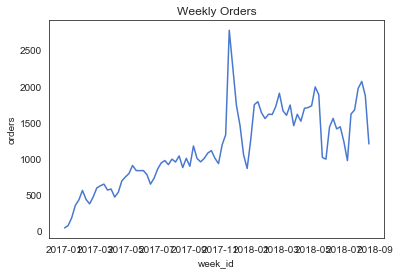

In [35]:
sns.lineplot(data=weekly_orders,
             x="week_id",
             y="orders").set_title("Weekly Orders");

Take a look at monthly data

In [20]:
monthly_orders_query = """
SELECT
    DATE_FORMAT(order_purchase_timestamp, '%Y-%m-01') AS month_id,
    COUNT(1)                                                                                     AS orders
FROM olist.orders
WHERE DATE(order_purchase_timestamp) >= '2017-01-01'
    AND DATE(order_purchase_timestamp) < '2018-09-01'
GROUP BY 1
ORDER BY 1;
"""

monthly_orders = pd.read_sql(monthly_orders_query, conn)

In [22]:
monthly_orders.head()

,month_id,orders
0,2017-01-01,800
1,2017-02-01,1780
2,2017-03-01,2682
3,2017-04-01,2404
4,2017-05-01,3700


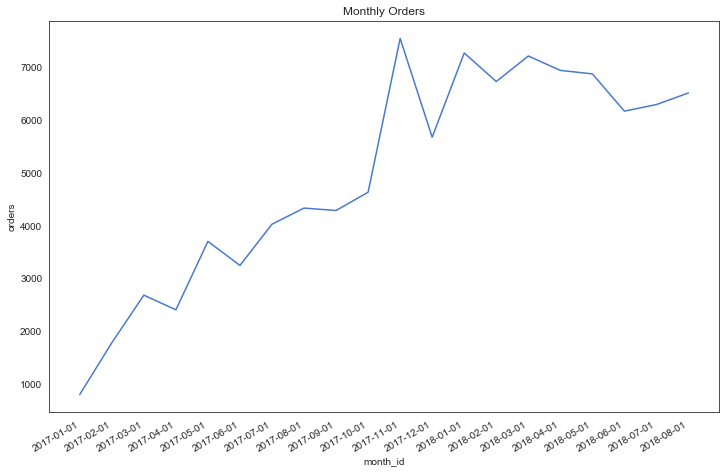

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=monthly_orders,
             x="month_id",
             y="orders").set_title("Monthly Orders");
# automatically rotate date ticks to not ovetrlap
fig.autofmt_xdate();

To account for seasonality, we may want to compare same months across years

In [26]:
orders_year_month_query = """
SELECT
    DATE_FORMAT(order_purchase_timestamp, '%Y-%m-01')   AS month_id,
    MONTH(order_purchase_timestamp)                     AS month_in_year,
    YEAR(order_purchase_timestamp)                      AS year,
    COUNT(1)                                            AS orders
FROM olist.orders
WHERE DATE(order_purchase_timestamp) >= '2017-01-01'
    AND DATE(order_purchase_timestamp) < '2018-09-01'
GROUP BY 1,2,3
ORDER BY 1;
"""

orders_year_month = pd.read_sql(orders_year_month_query, conn)

In [27]:
orders_year_month

,month_id,month_in_year,year,orders
0,2017-01-01,1,2017,800
1,2017-02-01,2,2017,1780
2,2017-03-01,3,2017,2682
3,2017-04-01,4,2017,2404
4,2017-05-01,5,2017,3700
5,2017-06-01,6,2017,3245
6,2017-07-01,7,2017,4026
7,2017-08-01,8,2017,4331
8,2017-09-01,9,2017,4285
9,2017-10-01,10,2017,4631


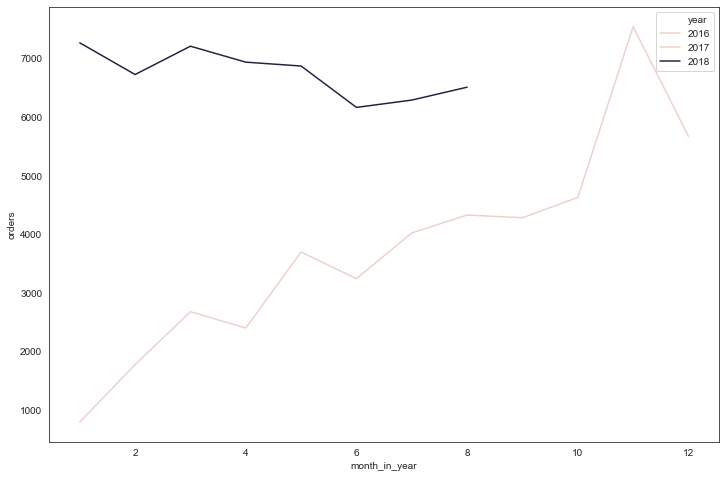

In [41]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=orders_year_month,
             x="month_in_year",
             y="orders",
             hue="year",
             ax=ax);

In [38]:
monthly_perf_query = """
SELECT
    DATE_FORMAT(o.order_purchase_timestamp, '%Y-%m-01') AS month_id,
    MONTH(o.order_purchase_timestamp)                   AS month_in_year,
    YEAR(o.order_purchase_timestamp)                    AS year,
    COUNT(1)                                            AS items_sold,
    COUNT(DISTINCT o.order_id)                          AS orders,
    SUM(oi.price)                                       AS revenue,
    COUNT(DISTINCT seller_id)                           AS sellers
FROM olist.orders o
    JOIN olist.order_items oi
    ON o.order_id = oi.order_id
WHERE TRUE
    AND DATE(order_purchase_timestamp) >= '2017-01-01'
    AND DATE(order_purchase_timestamp) < '2018-09-01'
GROUP BY 1,2,3
ORDER BY 1;
"""

monthly_perf = pd.read_sql(monthly_perf_query, conn)

In [39]:
monthly_perf

,month_id,month_in_year,year,items_sold,orders,revenue,sellers
0,2017-01-01,1,2017,955,789,1.203129e+05,227
1,2017-02-01,2,2017,1951,1733,2.473030e+05,427
2,2017-03-01,3,2017,3000,2641,3.743443e+05,499
3,2017-04-01,4,2017,2684,2391,3.599272e+05,506
4,2017-05-01,5,2017,4136,3660,5.060711e+05,583
5,2017-06-01,6,2017,3583,3217,4.330386e+05,539
6,2017-07-01,7,2017,4519,3969,4.980315e+05,606
7,2017-08-01,8,2017,4910,4293,5.739717e+05,708
8,2017-09-01,9,2017,4831,4243,6.244017e+05,731
9,2017-10-01,10,2017,5322,4568,6.642194e+05,776


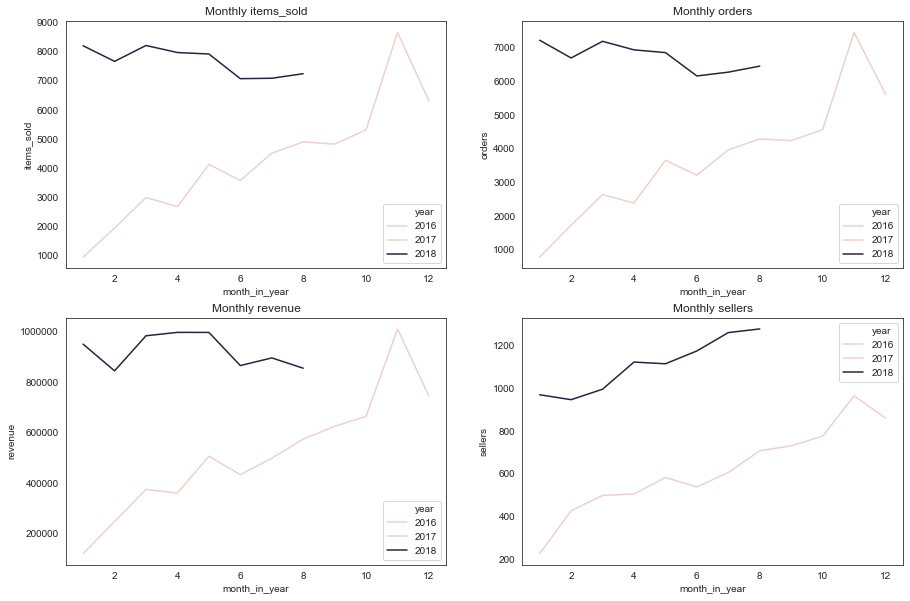

In [47]:
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         figsize=(15,10))

metrics = ["items_sold", "orders", "revenue", "sellers"]

i = 0
for ax in axes.flatten():
    sns.lineplot(data=monthly_perf,
                 x="month_in_year",
                 y=metrics[i],
                 hue="year",
                 ax=ax).set_title(f"Monthly {metrics[i]}")
    i+=1